# Governing equations
\begin{alignat}{2}
    &\rho \ddot{\mathbf{u}} = \text{div}[\mathbf{T}] + \rho b &&\qquad in \qquad \Omega \\ \\
    &\mathbf{u}(\mathbf{x}) = \mathbf{u}^{\mathrm{p}}(\mathbf{x}) && \qquad on \qquad \Gamma^D \\ \\
    &{\textbf{T}}\hat{\mathbf{n}}(x) = \mathbf{t}^{\mathrm{p}}(\mathbf{x}) && \qquad on \qquad \Gamma^N \\ \\
    &u(\mathbf{x},t=0) = u_0(x) && \qquad in \qquad \Omega \\ \\
    &\frac{\partial{\mathbf{u}}}{\partial{t}}(\mathbf{x},t=0) = v_0(x) && \qquad in \qquad \Omega
\end{alignat}

# Newmark Equations
\begin{alignat}{2}
&\\
&{\mathbf{u}}^{(n+1)} = {\mathbf{u}}^{(n)} + \Delta t {\mathbf{v}}^{(n)} + \frac{(\Delta t)^2}{2}\Big[(1-2\beta){\mathbf{a}}^{(n)} + 2\beta {\mathbf{a}}^{(n+1)}\Big]\\
\\
&{\mathbf{v}}^{(n+1)} = {\mathbf{v}}^{(n)} + \Delta t \Big[(1-\gamma){\mathbf{a}}^{(n)} + \gamma {\mathbf{a}}^{(n+1)}\Big]\\
\\
&{\mathbf{a}}^{(n+1)} = \frac{1}{\beta\Delta t^2}\left\{\mathbf{u}^{(n+1)} - \mathbf{u}^{(n)} - \Delta t {\mathbf{v}}^{(n)} \right\} - \frac{(1-2\beta)}{2\beta}{\mathbf{a}}^{(n)}
\end{alignat}

# Constitutive Equations
For plane strain:$\quad \mathbf{T} = \lambda\mathrm{tr}[\mathbf{E}]\mathbf{I} + 2\mu\mathbf{E}$
\begin{alignat}{1}
\lambda = \frac{\mathrm{E}\nu}{(1+\nu)(1-2\nu)} \quad \mu = \frac{\mathrm{E}}{2(1+\nu)}\\
\mathrm{E},\nu ~\text{are Young's modulus and Poissons ratio}
\end{alignat}

For plane stress:$\quad \mathbf{T} = \lambda^*\mathrm{tr}[\mathbf{E}]\mathbf{I} + 2\mu\mathbf{E}$
\begin{alignat}{2}
&\lambda^* = \frac{2\lambda\mu}{\lambda+2\mu}
\end{alignat}
\begin{alignat}{2}
\mathbf{E} = \frac{1}{2}\left(\mathrm{grad}[\mathbf{u}]+\mathrm{grad}{[\mathbf{u}]}^{\mathrm{T}}\right)
\end{alignat}


# Variational forms

\begin{alignat}{2}
&\text{Bilinear Form} &&= \int_{\Omega}~\frac{\rho}{\beta\Delta t^2}~({w\cdot u^{n+1}})d\Omega~+~\int_{\Omega}~\lambda~\text{div}{[w]}~\text{div}{[u^{n+1}]}d\Omega~+~\int_{\Omega}~\mu~\left\{\text{grad}[w]~\cdot~\left(\text{grad}[u^{n+1}]~+~\text{grad}[u^{n+1}]^T\right)\right\}d\Omega\\
\\
&\text{Linear Functional} &&= \int_{\Omega}\frac{\rho}{\beta \Delta t^2}(w\cdot u^n) d\Omega~+~\int_{\Omega}\frac{\rho}{\beta \Delta t}(w\cdot v^n) d\Omega~+~\int_{\Omega}\frac{\rho(1 - 2\beta)}{2\beta}(w\cdot a^n) d\Omega + \int_{d\Omega} (w\cdot t) d\Gamma
\end{alignat}


\begin{alignat}{2}
{factor}_1 = \frac{\rho}{\beta \Delta t^2}\qquad {factor}_2 = \frac{\rho}{\beta \Delta t}\qquad {factor}_3 = \frac{\rho(1 - 2\beta)}{2\beta}
\end{alignat}


In [1]:
%pylab inline
%matplotlib notebook
import matplotlib
import numpy as np
import random
import math
from pdb import set_trace as bp

Populating the interactive namespace from numpy and matplotlib


In [2]:
# from mshr import *
import numpy as np
from dolfin import *
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True

In [3]:
rm *.pvd *.vtu

rm: cannot remove '*.pvd': No such file or directory
rm: cannot remove '*.vtu': No such file or directory


In [4]:
# Form compiler options
# parameters["form_compiler"]["cpp_optimize"] = True
# parameters["form_compiler"]["optimize"] = True

In [5]:
"""
Lx & Ly : length in X and Y direction
base : original domain
numCircles : a counter to stop the mapping to not run forever
mu,sigma : mean and standard deviation of inclusions
porosity :  target porosity
currentPorosity : calculated porosity at a perticular point
offset : to make circles not go out of domain
"""
Lx,Ly = 1,0.2
nx = 50
ny = np.ceil(nx*Ly)

FORCED = 1
longitudinal = 1

T = 1e-3
tForce = 0.3*T

# model = "PlaneStress"
model = "PlaneStrain"

shear = int(not longitudinal)

# domain = Rectangle(Point(0, 0), Point(Lx, Ly))

if FORCED == 0:
    d0 = 1e-3
    p0 = 0
else:
    p0 = -1.7e3
    d0 = 0

E = 30e9
rho = 3150
nu = -0.3

lmda = (E*nu) / ((1+nu)*(1 - (2*nu)))

mu = E/(2*(1+nu))

if model == "PlaneStress":
    lmda = 2*mu*lmda/(lmda+2*mu)


nT = 100
dt = T/nT

t = np.linspace(0, T, nT,endpoint=True)

Energies = np.zeros((nT,4))
tip1 = (Lx,Ly)
# tip2 = (0.75*Lx,0.5*Ly)

dispTip1 = np.zeros((nT,2))
# dispTip2 = np.zeros((nT,2))

beta,gamma = 0.25,0.5

omega,dOmega = 1,2

numCircles = 500
poreMu,poreSigma = 0.25,0.0001
location = [0,0]
poreDiameter = []
numCir = int(0)
currentInclusionVolume = 0
offset = 0.5*poreMu#+poreSigma

inclusionVolume = 0.

In [6]:
print("Total time = ",T)
print("Time step = ",dt)


Total time =  0.001
Time step =  1e-05


In [7]:
if inclusionVolume>0:
    while numCir<numCircles:

        xlocation = Lx * np.random.rand()
        ylocation = Lx * np.random.rand()

        if xlocation < offset or xlocation > Lx - offset:
            continue

        if ylocation < offset or ylocation > Ly - offset:
            continue
        dia = np.random.normal(poreMu, poreSigma, 1)

        if numCir>1:
            distance = np.sqrt((xlocation-location[:,0])**2 + (ylocation-location[:,1])**2)
            check = 0.5*dia > (1-((0.5*poreDiameter)
                                  /distance))*distance
            cond = any(check)
            if cond==True:
                continue

        currentInclusionVolume = (currentInclusionVolume + 0.25*3.14*dia**2)
        if currentInclusionVolume >= inclusionVolume:
            break
        currentlocation = [xlocation,ylocation]
        poreDiameter = np.concatenate((poreDiameter, dia),axis=0)
        location = np.vstack((location,currentlocation))

        if numCir==0:
            location=location[1:,:]

        numCir += 1
    print("Number of inclusions = ",numCir)
    print("Porosity acheived = ",currentInclusionVolume.tolist())

    for i in range(numCir):
        hole = Circle(Point(location[i,0],location[i,1]), 0.5*poreDiameter[i])
        domain = domain - hole

In [8]:
# mesh = generate_mesh(domain,nx)
mesh = RectangleMesh(Point(0,0),Point(Lx,Ly),int(nx),int(ny),"crossed")
boundaries = MeshFunction("size_t",mesh, mesh.topology().dim()-1)
solSpace = VectorFunctionSpace(mesh,"CG",1)
# figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
# plot(mesh)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [9]:
class left_bnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0],0.0)

class right_bnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near (x[0],Lx)

class top_bnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near (x[1],Ly)
    
class bottom_bnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near (x[1],0)

left = left_bnd()
right = right_bnd()
top = top_bnd()
bottom = bottom_bnd()

boundaries.set_all(0)
left.mark(boundaries,1)
right.mark(boundaries,2)
bottom.mark(boundaries,3)
top.mark(boundaries,4)

ds = Measure("ds")[boundaries]

bcl = DirichletBC(solSpace,Constant((0.0,0.0)),left)

Notation dx[meshfunction] is deprecated. Please use dx(subdomain_data=meshfunction) instead.


In [10]:
testFunc = TestFunction(solSpace)
trialFunc = TrialFunction(solSpace)

nD = trialFunc.geometric_dimension() #Spatial dimension

dispBefore = Function(solSpace,name="Displacement")

if FORCED==0:
    dispBefore = interpolate(Expression(("Longitudinal*d0*x[0]","Shear*d0*x[0]"),\
                                        d0=d0,Longitudinal=longitudinal,\
                                        Shear=shear,degree=4),solSpace)
else:
    dispBefore = Function(solSpace,name="Displacement")

velBefore = Function(solSpace,name="Velocity")
accBefore = Function(solSpace,name="Acceleration")

In [11]:
dispTip1[0,0],dispTip1[0,1] = dispBefore(tip1)[0],dispBefore(tip1)[1]
# dispTip2[0,0],dispTip2[0,1] = dispBefore(tip2)[0],dispBefore(tip2)[1]

In [12]:
# # Stress tensor
def sigma(r):
    return 2.0*mu*sym(grad(r)) + lmda*tr(sym(grad(r)))*Identity(len(r))

def epslon(r):
    return sym(grad(r))*Identity(len(r))

# # Mass form
def m(u, w):
    return rho*inner(u, w)*dx

# # Elastic stiffness form
def k(u, w):
    return inner(sigma(u), sym(grad(w)))*dx

def p(step):
#     P_ = Constant((1.0,0.0))
#     P_ = Expression(("tc <= tF ? p0 : 0","0.0"),tc=t[step], tF=tForce, p0=p0,degree=2)
#     P_ = Expression(("tc <= tF ? p0*tc/tF : 0","0."), tc=t[step], tF=tForce, p0=p0, degree=0)
    P_ = Expression(("tc <= tF ? Longitudinal*p0*sin(omega*pi*tc/tF)*sin(dOmega*pi*tc/tF) : 0",\
                     "tc <= tF ? Shear*p0*sin(omega*pi*tc/tF)*sin(dOmega*pi*tc/tF) : 0"),\
                    tc=t[step],tF=tForce,p0=p0,omega=omega,dOmega=dOmega,degree=2,\
                    Longitudinal=longitudinal,Shear=shear)
    return P_

def fExt(testFunc,step):
    forceApplied = inner(p(step),testFunc)*ds(2)
    force = assemble(forceApplied)
    forceVec=force.get_local()
#     print([step,forceVec])
#     bp()
    return forceVec

In [13]:
def update_Deform(dispAfter, dispBefore,velBefore,accBefore,beta, gamma, dt):
    """Update fields at the end of each time step."""

    # Get vectors (references)
    dispAfter_vec, dispBefore_vec  = dispAfter.vector(), dispBefore.vector()
    velBefore_vec, accBefore_vec = velBefore.vector(), accBefore.vector()
    
    # Update acceleration and velocity
    
    accAfter_vec = (1.0/(2.0*beta))*( (dispAfter_vec - dispBefore_vec \
                                      - (velBefore_vec*dt))/(0.5*dt*dt) \
                                     - (1.0-2.0*beta)*accBefore_vec )

    velAfter_vec = dt*((1.0-gamma)*accBefore_vec + gamma*accAfter_vec) + velBefore_vec

    velBefore.vector()[:], accBefore.vector()[:] = velAfter_vec, accAfter_vec
    dispBefore.vector()[:] = dispAfter.vector()

In [14]:
K = PETScMatrix()
M = PETScMatrix()

assemble(k(trialFunc,testFunc), tensor=K)
assemble(m(trialFunc,testFunc), tensor=M)
bcl.apply(K)
bcl.apply(M)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [15]:
ep = 0.5*np.dot(dispBefore.vector(),np.dot(K.array(),dispBefore.vector()))
ek = 0.5*np.dot(velBefore.vector(),np.dot(M.array(),velBefore.vector()))
if FORCED==1:
    eExt = np.dot(fExt(testFunc,0),velBefore.vector())
else:
    eExt = ep+ek
    
Energies[0,:] = [ep,ek,eExt,ep+ek]

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [16]:
print(ep+ek)

0.0


In [17]:
dispAfter = Function(solSpace)
velAfter = Function(solSpace)
accAfter = Function(solSpace)

forceApplied = inner(p(2),testFunc)*ds(2)
force = assemble(forceApplied)
forceVec=force.get_local()
  

aI = np.linalg.solve(M.array(), fExt(testFunc,0)-np.dot(K.array(),dispBefore.vector()))

accBefore.vector()[:] = aI

In [18]:
# xdmf_file = XDMFFile("results/elastodynamics_results_{}_forced_{}_longitudinal_{}_shear_{}.xdmf".format(\
#                                 model,FORCED,longitudinal,shear))

# xdmf_file.parameters["flush_output"] = True
# xdmf_file.parameters["functions_share_mesh"] = True
# xdmf_file.parameters["rewrite_function_mesh"] = False
# dispBefore.rename("Displacement","")
# xdmf_file.write(dispBefore, 0.)
# xdmf_file.write(velBefore, 0.)
# xdmf_file.write(accBefore, 0.)

## Bilinear Form

\begin{equation}
\text{Bilinear Form} = \int_{\Omega}~\frac{\rho}{\beta\Delta t^2}~({w\cdot u^{n+1}})d\Omega~+~\int_{\Omega}~\lambda~\text{div}{[w]}~\text{div}{[u^{n+1}]}d\Omega~+~\int_{\Omega}~\mu~\left\{\text{grad}[w]~\cdot~\left(\text{grad}[u^{n+1}]~+~\text{grad}[u^{n+1}]^T\right)\right\}d\Omega\\
\end{equation}

In [19]:
factor1 = 1/(beta*dt*dt)
factor2 = 1/(beta*dt)
factor3 = (1 - 2*beta)/(2*beta)

print('beta=',beta,'gamma=',gamma,'dt=',dt)

a =  factor1*rho*dot(testFunc,trialFunc) * dx +\
     lmda*div(testFunc)*div(trialFunc)*dx+\
     mu*inner(grad(testFunc),(grad(trialFunc)+grad(trialFunc).T))*dx

beta= 0.25 gamma= 0.5 dt= 1e-05


## Linear Functional
\begin{equation}
\text{Linear Functional} = \int_{\Omega}\frac{\rho}{\beta \Delta t^2}(w\cdot u^n) d\Omega~+~\int_{\Omega}\frac{\rho}{\beta \Delta t}(w\cdot v^n) d\Omega~+~\int_{\Omega}\frac{\rho(1 - 2\beta)}{2\beta}(w\cdot a^n) d\Omega + \int_{d\Omega} (w\cdot t) d\Gamma
\end{equation}


In [20]:
for i in np.arange(1,nT):
    tt = t[i]
    L = factor1*rho*inner(testFunc,dispBefore)*dx+\
        factor2*rho*inner(testFunc,velBefore)*dx +\
        factor3*rho*inner(testFunc,accBefore)*dx + inner(p(i),testFunc)*ds(2)
    
    solve(a == L,dispAfter,bcl)
        
    update_Deform(dispAfter, dispBefore, velBefore, accBefore, beta, gamma, dt)   
    
    dispTip1[i,0],dispTip1[i,1] = dispBefore(tip1)[0],dispBefore(tip1)[1]
#     dispTip2[i,0],dispTip2[i,1] = dispBefore(tip2)[0],dispBefore(tip2)[1]


    dispBefore.rename("Displacement","")
#     xdmf_file.write(dispBefore, i)
#     xdmf_file.write(velBefore, i)
#     xdmf_file.write(accBefore, i)
    
    ep = 0.5*np.dot(dispBefore.vector(),np.dot(K.array(),dispBefore.vector()))
    ek = 0.5*np.dot(velBefore.vector(),np.dot(M.array(),velBefore.vector()))
    
    if FORCED ==1:
        eExt = np.dot(fExt(testFunc,i),velBefore.vector())
    else:
        eExt = eExt
        
    Energies[i,:] = [ep,ek,eExt,ep+ek]

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [21]:
## Name of the output file
print("results/elastodynamics_results_{}_forced_{}_longitudinal_{}_shear_{}.xdmf".format(\
                                model,FORCED,longitudinal,shear))

results/elastodynamics_results_PlaneStrain_forced_1_longitudinal_1_shear_0.xdmf


<IPython.core.display.Javascript object>


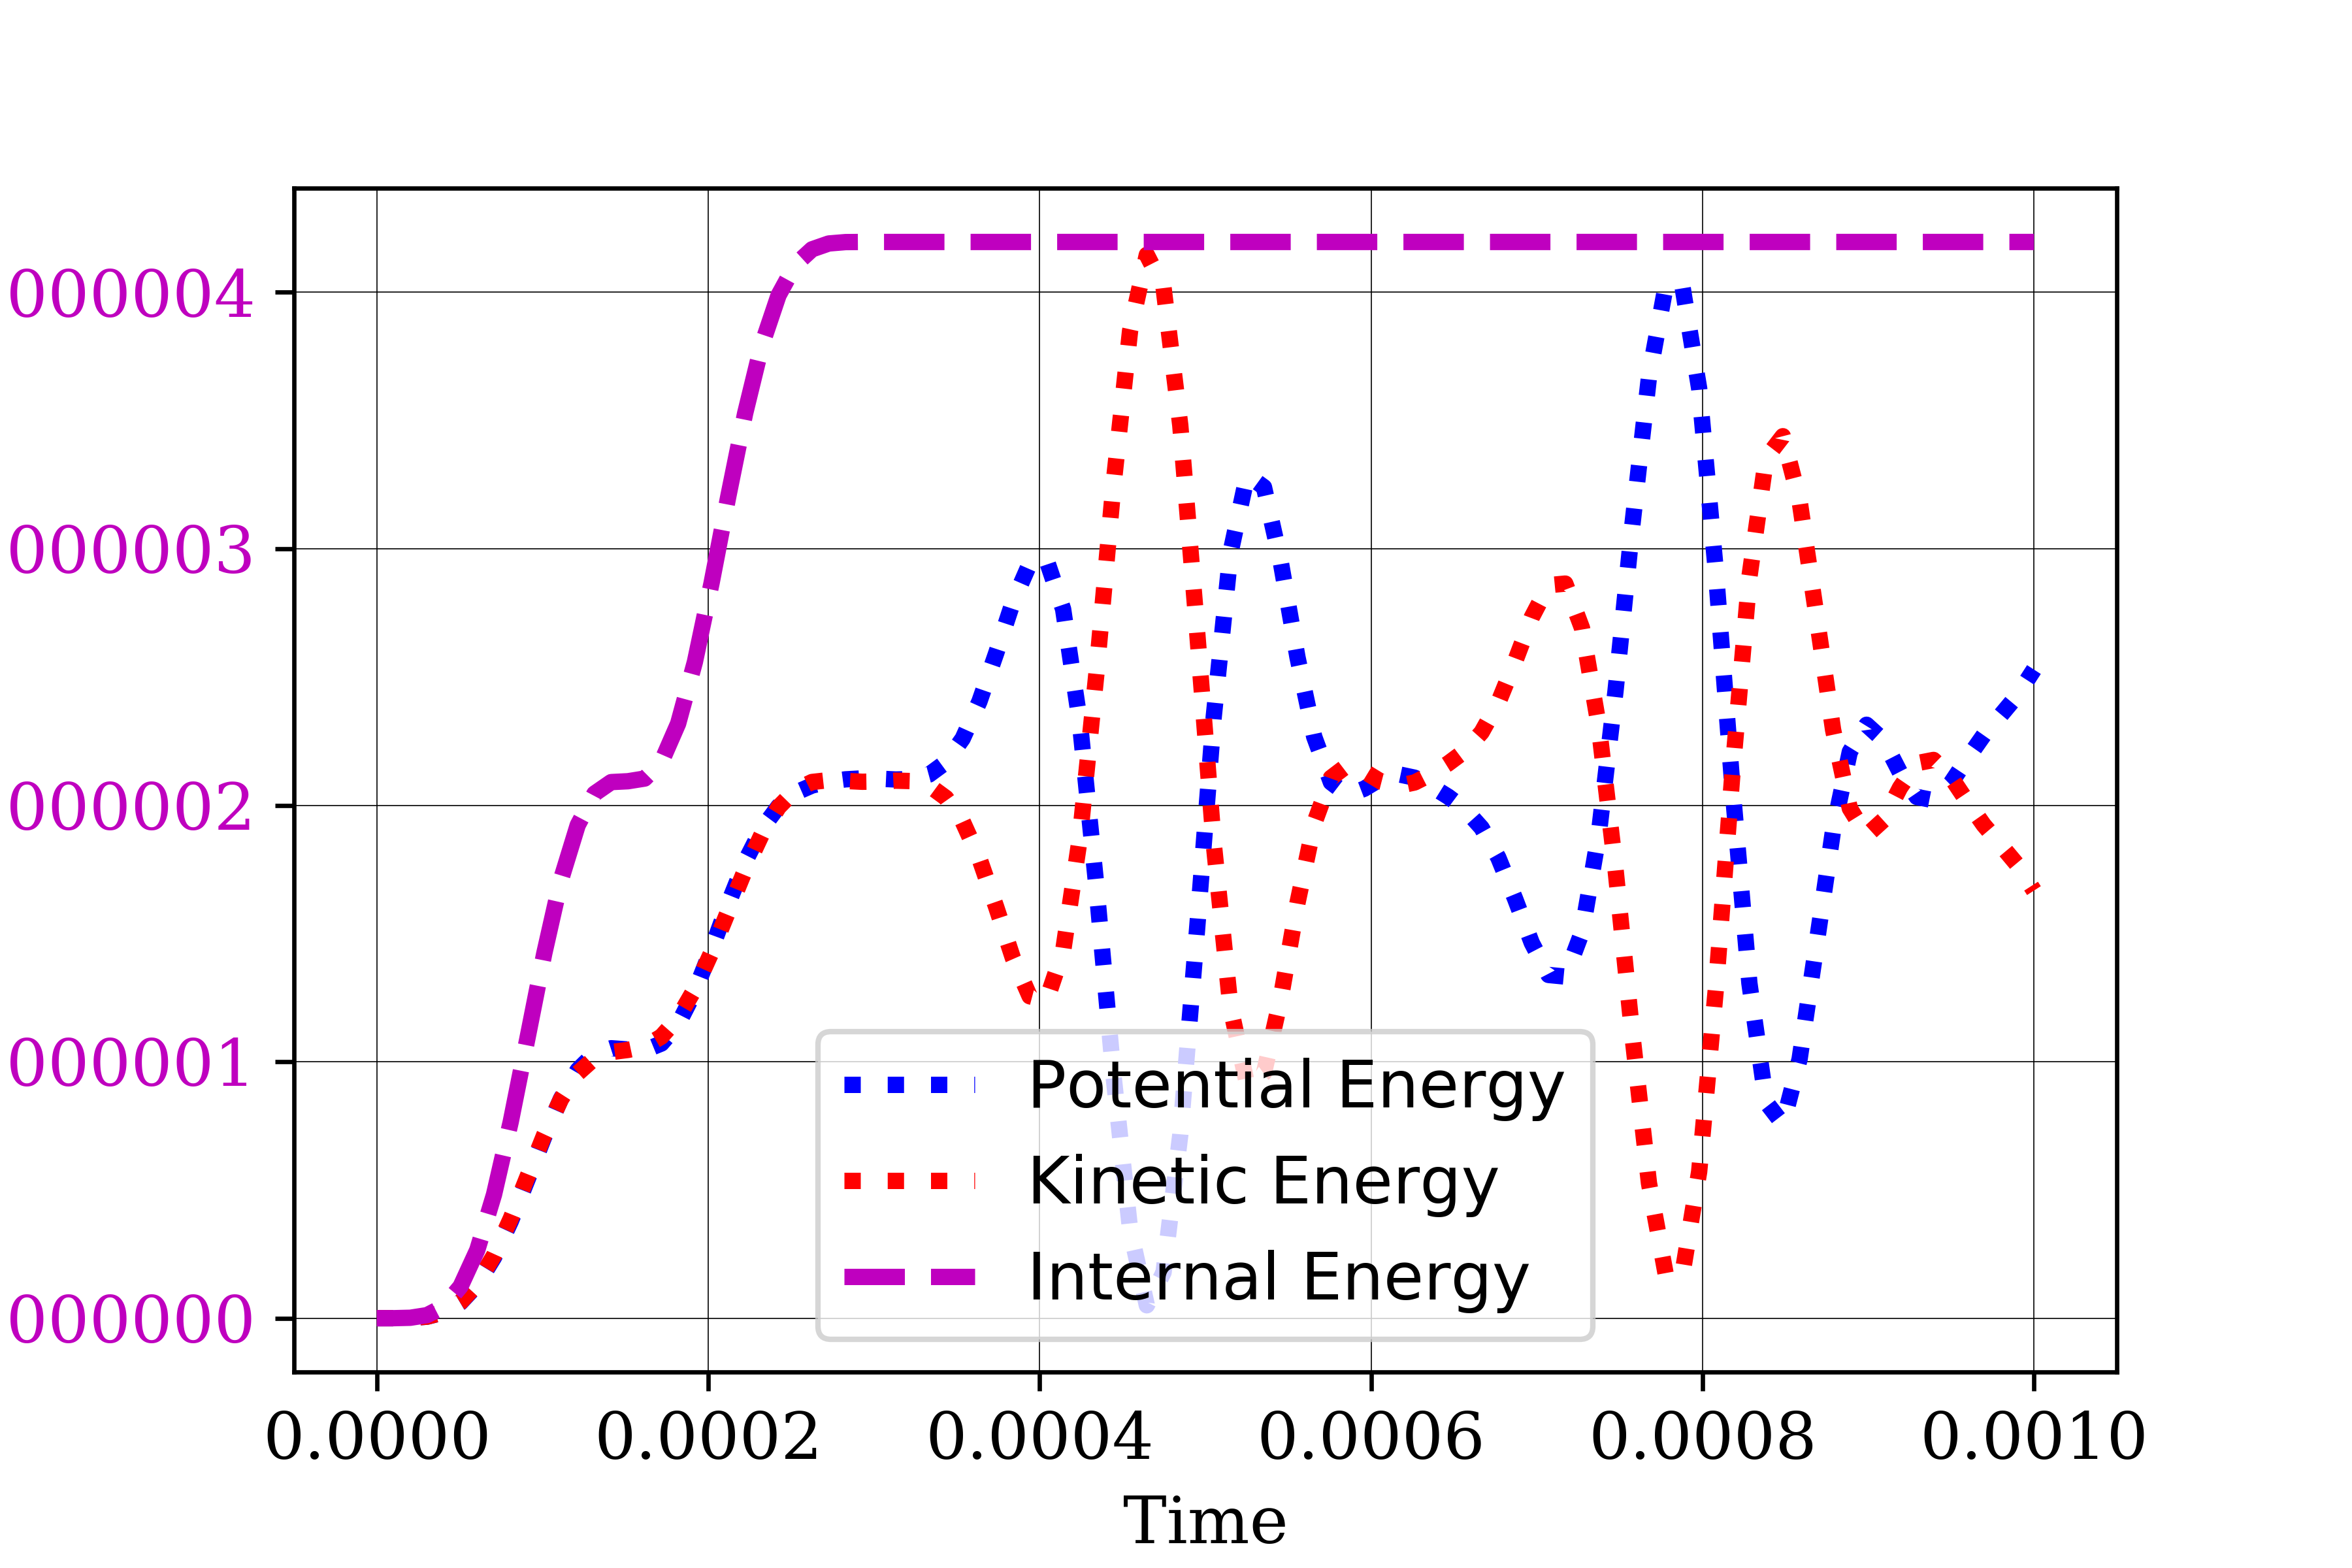

In [22]:
fig, ax1 = plt.subplots(num=None, figsize=(6, 4), dpi=300, facecolor='w', edgecolor='k')
grid(color='k',linewidth=0.2)
ax1.set_xlabel("Time",size=12,fontfamily='serif')
ax1.set_ylabel("Internal Energy",color='m',size=12,fontfamily='serif')
ax1.plot(t,Energies[:,0],':b',t,Energies[:,1],':r',t,Energies[:,3],'m--',linewidth=3)
plt.xticks(color='k', size=12,fontfamily='serif')
plt.yticks(color='m', size=12,fontfamily='serif')
ax1.legend(("Potential Energy","Kinetic Energy","Internal Energy"),fontsize=12)
# if FORCED ==1:
#     ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
#     ax2.set_ylabel('External Energy',color='g',size=12,fontfamily='serif')
#     ax2.plot(t, Energies[:,2],'g',linewidth=3)
#     ax2.legend(("External Energy"))
#     plt.yticks(color='g', size=12,fontfamily='serif')
# else:
#     ax1.plot(t, Energies[:,2],'k',linewidth=1)
    
np.savetxt("results/Energy_Continuum_{}_forced_{}_longitudinal_{}_shear_{}_AR_{}_E_{}_nu_{}.dat".format(\
                                model,FORCED,longitudinal,shear,Ly/Lx,E/1e9,nu), Energies)
plt.savefig("results/Energy_Continuum_{}_forced_{}_longitudinal_{}_shear_{}_AR_{}_E_{}_nu_{}_nx_{}.png".format(\
                                model,FORCED,longitudinal,shear,Ly/Lx,E/1e9,nu,nx),bbox_inches='tight')

<IPython.core.display.Javascript object>


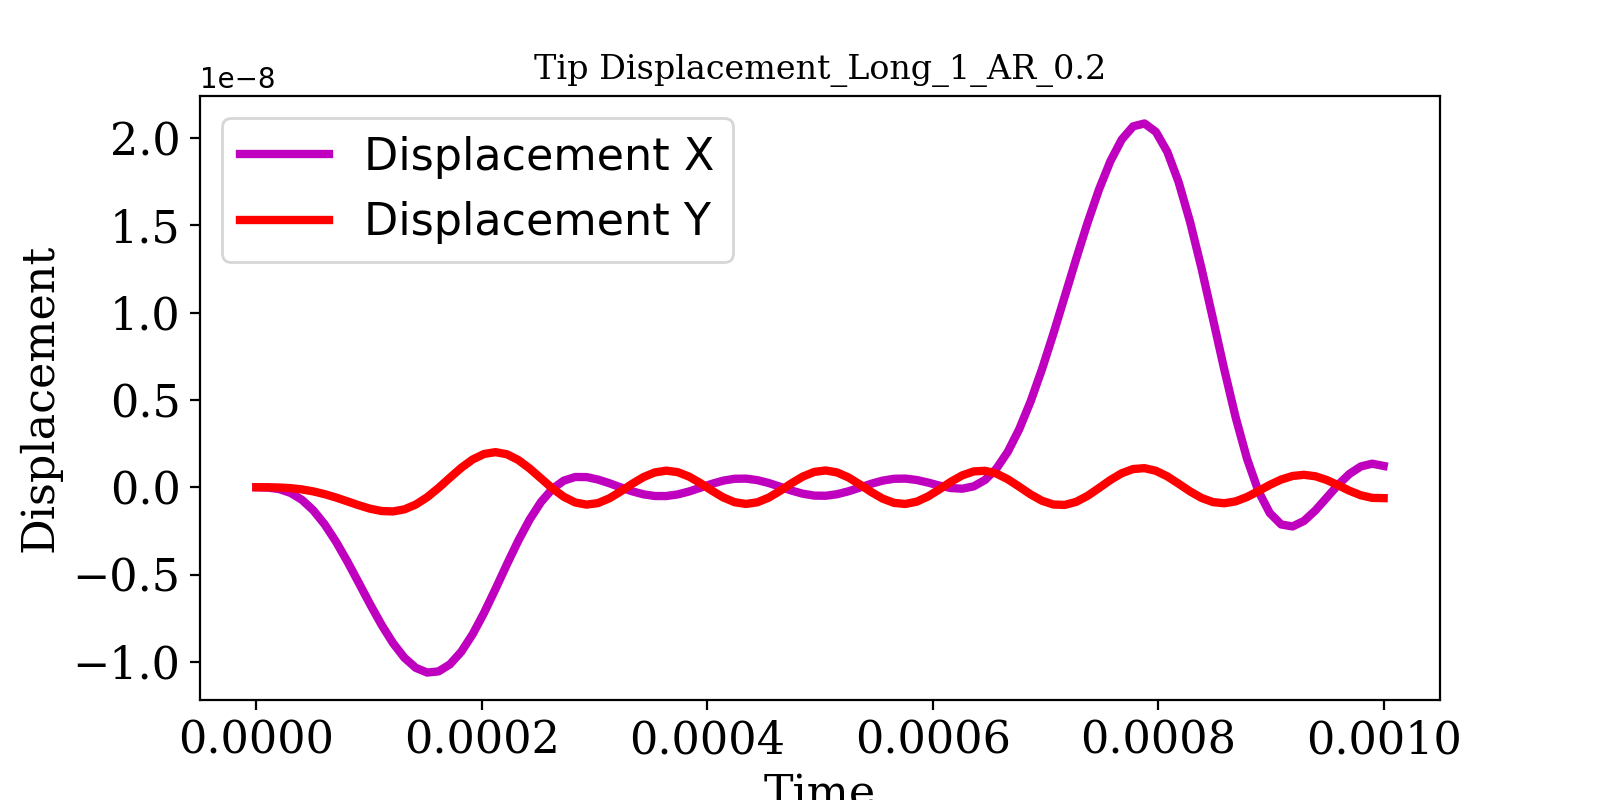

In [23]:
figure(num=None, figsize=(8, 4), dpi=100, facecolor='w', edgecolor='k')
plt.plot(t,dispTip1[:,0],'m',linewidth=3)
plt.plot(t,dispTip1[:,1],'r',linewidth=3)

# plt.plot(t,dispTip2[:,0],'r',linewidth=3)
plt.xlabel("Time",size=16,fontfamily='serif')
plt.ylabel("Displacement",size=16,fontfamily='serif')
plt.xticks(color='k', size=16,fontfamily='serif')
plt.yticks(color='k', size=16,fontfamily='serif')
plt.legend(("Displacement X","Displacement Y"),fontsize=16)
np.savetxt("results/tipDisplacement_Continuum_{}_forced_{}_longitudinal_{}_shear_{}_AR_{}_E_{}_nu_{}.dat".format(\
                               model,FORCED,longitudinal,shear,Ly/Lx,E/1e9,nu), dispTip1)

plt.title("Tip Displacement_Long_{}_AR_{}".format(longitudinal,Ly/Lx),fontfamily='serif')

plt.savefig("results/tipDisplacement_Continuum_{}_forced_{}_longitudinal_{}_shear_{}_AR_{}_E_{}_nu_{}_nx_{}.png".format(\
                               model,FORCED,longitudinal,shear,Ly/Lx,E/1e9,nu,nx),bbox_inches='tight')